In [1]:
# %load input_data

import tensorflow as tf
import numpy as np
import os
import pandas as pd
import csv
import numpy as np
from ast import literal_eval


# you need to change this to your data directory
train_dir ='F:/Udacity ML/git/udacity-capstone'
#Function to load the list of image file paths and its labels.
def get_files():
    '''
    
    Returns:
        list of images and labels

    '''
    #print(tf.__version__)
    print ("Loading files...")
    image_list=[]
    label_list=[]
    
    with open('F:/Udacity ML/git/udacity-capstone/images10.csv') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
                        
            image_list.append(row[0])
            temp=literal_eval(row[1])            
            label_list.append(temp)
    #print (type(image_list[0]))
    #print (type(label_list[0]))
    print ("Files list loaded.")
    return image_list, label_list

#Function to generate batches of images and labels
def get_batch(image, label, image_W, image_H, batch_size, capacity):
    '''
    Args:
        image: list type
        label: list type
        image_W: image width
        image_H: image height
        batch_size: batch size
        capacity: the maximum elements in queue
    Returns:
        image_batch: 4D tensor [batch_size, width, height, 3], dtype=tf.float32
        label_batch: 1D tensor [batch_size], dtype=tf.int32
    '''       
    image = tf.cast(image, tf.string)#cast image list values to string tensors
    label = tf.to_int32(label)
    
    input_queue = tf.train.slice_input_producer([image, label]) #Produces a slice of each Tensor in [image,label] list.
    #num_epochs: An integer (optional). If specified, slice_input_producer produces each slice num_epochs times
    #before generating an OutOfRange error. 
    #If not specified, slice_input_producer can cycle through the slices an unlimited number of times.
    
    label = input_queue[1]
    
    image_contents = tf.read_file(input_queue[0])
    image = tf.image.decode_jpeg(image_contents, channels=3)

    # data argumentation should go to here ########################################
    
    image = tf.image.resize_image_with_crop_or_pad(image, image_W, image_H)
    
    
    image = tf.image.per_image_standardization(image)
    
    image_batch, label_batch = tf.train.batch([image, label],
                                                batch_size= batch_size,
                                                num_threads= 2, 
                                                capacity = capacity)
    
    
    label_batch = tf.reshape(label_batch, [batch_size])
    image_batch = tf.cast(image_batch, tf.float32)
    
    return image_batch, label_batch

In [2]:
# %load model
import tensorflow as tf

#Function to build the convolution model
def inference(images, batch_size, n_classes):
    '''Build the model
    Args:
        images: image batch, 4D tensor, tf.float32, [batch_size, width, height, channels]
    Returns:
        output tensor with the computed logits, float, [batch_size, n_classes]
    '''
    #conv1, shape = [kernel size, kernel size, channels, kernel numbers]
    
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable('weights', 
                                  shape = [3,3,3, 16],
                                  dtype = tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases', 
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(images, weights, strides=[1,1,1,1], padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name= scope.name)
    
    #pool1 and norm1   
    with tf.variable_scope('pooling1_lrn') as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],
                               padding='SAME', name='pooling1')
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm1')
    
    #conv2
    with tf.variable_scope('conv2') as scope:
        weights = tf.get_variable('weights',
                                  shape=[3,3,16,16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[16], 
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(norm1, weights, strides=[1,1,1,1],padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name='conv2')
    
    
    #pool2 and norm2
    with tf.variable_scope('pooling2_lrn') as scope:
        norm2 = tf.nn.lrn(conv2, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm2')
        pool2 = tf.nn.max_pool(norm2, ksize=[1,3,3,1], strides=[1,1,1,1],
                               padding='SAME',name='pooling2')
    
    
    #local3
    with tf.variable_scope('local3') as scope:
        reshape = tf.reshape(pool2, shape=[batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = tf.get_variable('weights',
                                  shape=[dim,128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)    
    
    #local4
    with tf.variable_scope('local4') as scope:
        weights = tf.get_variable('weights',
                                  shape=[128,128],
                                  dtype=tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name='local4')
     
        
    # softmax
    with tf.variable_scope('softmax_linear') as scope:
        weights = tf.get_variable('softmax_linear',
                                  shape=[128, n_classes],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases', 
                                 shape=[n_classes],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name='softmax_linear')
    
    return softmax_linear


def losses(logits, labels):
    '''Compute loss from logits and labels
    Args:
        logits: logits tensor, float, [batch_size, n_classes]
        labels: label tensor, tf.int32, [batch_size]
        
    Returns:
        loss tensor of float type
    '''
    with tf.variable_scope('loss') as scope:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='xentropy_per_example')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
    return loss


def trainning(loss, learning_rate):
    '''Training ops, the Op returned by this function is what must be passed to 
        'sess.run()' call to cause the model to train.
        
    Args:
        loss: loss tensor, from losses()
        
    Returns:
        train_op: The op for trainning
    '''
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = optimizer.minimize(loss, global_step= global_step)
    return train_op


def evaluation(logits, labels):
    """Evaluate the quality of the logits at predicting the label.
      Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES].
        labels: Labels tensor, int32 - [batch_size], with values in the
        range [0, NUM_CLASSES).
      Returns:
        A scalar int32 tensor with the number of examples (out of batch_size)
        that were predicted correctly.
    """
    with tf.variable_scope('accuracy') as scope:
        correct = tf.nn.in_top_k(logits, labels, 1)
        correct = tf.cast(correct, tf.float16)
        accuracy = tf.reduce_mean(correct)
        tf.summary.scalar(scope.name+'/accuracy', accuracy)
    return accuracy



1.2.1
<class 'str'>
<class 'int'>
Hello
<class 'str'>
<class 'int'>
['F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/81_left.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/81_right.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/84_left.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/84_right.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/99_right.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/99_left.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/104_left.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/104_right.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/111_left.jpeg', 'F:/Diabetic Retinopathy/TrainDataPreProcessed/FinalData/111_right.jpeg']
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
label: 1


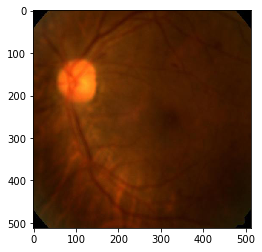

label: 0


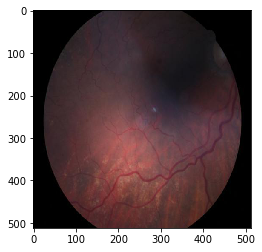

In [3]:
import os
import numpy as np
import tensorflow as tf
import input_data
import model

#%%

N_CLASSES = 2
IMG_W = 512  # resize the image, if the input image is too large, training will be very slow.
IMG_H = 512
BATCH_SIZE = 5
CAPACITY = 2
MAX_STEP = 50 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.1 # with current parameters, it is suggested to use learning rate<0.0001


#%%
def run_training():
    
    # you need to change the directories to yours.
    
    logs_train_dir = '/board/'
    
    train, train_label = get_files()
    
    train_batch, train_label_batch = get_batch(train,train_label,IMG_W,IMG_H,BATCH_SIZE,CAPACITY)      
    train_logits = inference(train_batch, BATCH_SIZE, N_CLASSES)
    train_loss = losses(train_logits, train_label_batch)        
    train_op = trainning(train_loss, learning_rate)
    train__acc =evaluation(train_logits, train_label_batch)
       
    summary_op = tf.summary.merge_all()
    sess = tf.Session()
    train_writer = tf.summary.FileWriter(logs_train_dir, sess.graph)
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                    break
            _, tra_loss, tra_acc = sess.run([train_op, train_loss, train__acc])
               
            if step % 5 == 0:
                print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))
                summary_str = sess.run(summary_op)
                train_writer.add_summary(summary_str, step)
            
            if step % 10 == 0 or (step + 1) == MAX_STEP:
                checkpoint_path = os.path.join(logs_train_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)
                
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        coord.request_stop()
        
    coord.join(threads)
    sess.close()
    



In [4]:
tf.reset_default_graph() 
print ("Training started.")

run_training()
print ("training ended.")

Training started.
Loading files...
Files list loaded.
Step 0, train loss = 0.70, train accuracy = 0.00%
Step 5, train loss = 0.60, train accuracy = 79.98%
Step 10, train loss = 0.53, train accuracy = 79.98%
Step 15, train loss = 0.50, train accuracy = 79.98%
Step 20, train loss = 0.51, train accuracy = 79.98%
Step 25, train loss = 0.15, train accuracy = 100.00%
Step 30, train loss = 0.51, train accuracy = 79.98%
Step 35, train loss = 0.18, train accuracy = 100.00%
Step 40, train loss = 0.20, train accuracy = 100.00%
Step 45, train loss = 0.80, train accuracy = 60.01%
training ended.


In [5]:
# %load input_data

import tensorflow as tf
import numpy as np
import os
import pandas as pd
import csv
import numpy as np
from ast import literal_eval


# you need to change this to your data directory
train_dir ='F:/Udacity ML/git/udacity-capstone'

def get_files_test():
    '''
    Args:
        file_dir: file directory
    Returns:
        list of images and labels

    '''
    print(tf.__version__)
    
    image_list=[]
    label_list=[]
    
    with open('test10.csv') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
                        
            image_list.append(row[0])
            temp=literal_eval(row[1])            
            label_list.append(temp)
    #print (type(image_list[0]))
    #print (type(label_list[0]))
    
    return image_list, label_list

def get_batch_test(image, label, image_W, image_H, batch_size, capacity):
    '''
    Args:
        image: list type
        label: list type
        image_W: image width
        image_H: image height
        batch_size: batch size
        capacity: the maximum elements in queue
    Returns:
        image_batch: 4D tensor [batch_size, width, height, 3], dtype=tf.float32
        label_batch: 1D tensor [batch_size], dtype=tf.int32
    '''
    
    image = tf.cast(image, tf.string)#cast image list values to string tensors
    label = tf.to_int32(label)  


    # make an input queue
    input_queue = tf.train.slice_input_producer([image, label])    
    label = input_queue[1]
    
    image_contents = tf.read_file(input_queue[0])
    
    image = tf.image.decode_jpeg(image_contents, channels=3)
    
    ######################################
    # data argumentation should go to here
    ######################################
    image = tf.image.resize_image_with_crop_or_pad(image, image_W, image_H)
    
    
    image = tf.image.per_image_standardization(image)
    
          
    image_batch, label_batch = tf.train.batch([image, label],
                                                batch_size= batch_size,
                                                num_threads= 2, 
                                                capacity = capacity)
    
    
    
    label_batch = tf.reshape(label_batch, [batch_size])
    image_batch = tf.cast(image_batch, tf.float32)
    
    return image_batch, label_batch


In [18]:
#%% Evaluate one image
# when training, comment the following codes.


from PIL import Image
import matplotlib.pyplot as plt

def get_one_image(train):
    '''Randomly pick one image from training data
    Return: ndarray
    '''
    n = len(train)
    ind = np.random.randint(0, n)
    img_dir = train[ind]

    image = Image.open(img_dir)
    plt.imshow(image)
    image = image.resize([208, 208])
    image = np.array(image)
    return image

def evaluate_test():
    
    IMG_W = 512  
    IMG_H = 512
    BATCH_SIZE = 2
    CAPACITY = 2
    tf.reset_default_graph() 
    test, test_label = get_files_test()#load the test image paths and labels
  
    
    test_batch, test_label_batch = get_batch_test(test,test_label,IMG_W,IMG_H,BATCH_SIZE,CAPACITY)#get images and lables batches  
       
    coord = tf.train.Coordinator()
    
    
    #with tf.Graph().as_default():            
             
    logit = inference(test_batch, BATCH_SIZE, N_CLASSES)        
    logit = tf.nn.softmax(logit)
    x = tf.placeholder(tf.float32, shape=[BATCH_SIZE,512, 512, 3])
        
    # you need to change the directories to yours.
    logs_train_dir = '/board/' 
                       
    saver = tf.train.Saver()
        
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        print("Reading checkpoints...")
        ckpt = tf.train.get_checkpoint_state(logs_train_dir)
        if ckpt and ckpt.model_checkpoint_path:
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('Loading success, global_step is %s' % global_step)
        else:
            print('No checkpoint file found')
            
        prediction = sess.run(logit)
        test_acc= sess.run(evaluation(prediction, test_label_batch))
        print (test_acc)
            
    coord.request_stop()
           
    coord.join(threads)
    sess.close()          


evaluate_test()

1.2.1
Reading checkpoints...
INFO:tensorflow:Restoring parameters from /board/model.ckpt-49
Loading success, global_step is 49
1.0
